<a href="https://colab.research.google.com/github/Nanungi/Prediction-of-Product-Sales/blob/main/WFP_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [41]:
#libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing tools
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Deep learning tools

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import set_config
set_config(transform_output='pandas')


#Keras
from tensorflow.keras import Sequential
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense, Dropout

#Sci-kit Learn
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Setting options
n=800
pd.set_option('display.max_columns',n)
pd.set_option("display.max_info_rows", n)
pd.set_option('display.max_info_columns',n)
from sklearn import set_config
set_config(transform_output='pandas')


In [3]:
# Custom function for plotting each metric
def plot_history(history, figsize=(6,12), marker='o'):

    # Get list of metrics from history
    metrics = [c for c in history.history if not c.startswith('val_')]

    ## Separate row for each metric
    fig, axes = plt.subplots(nrows=len(metrics),figsize=figsize)

    # For each metric
    for i, metric_name in enumerate(metrics):

        # Get the axis for the current metric
        ax = axes[i]

        # Get metric from history.history
        metric_values = history.history[metric_name]
        # Get epochs from history
        epochs = history.epoch

        # Plot the training metric
        ax.plot(epochs, metric_values, label=metric_name, marker=marker)

        ## Check if val_{metric} exists. if so, plot:
        val_metric_name = f"val_{metric_name}"
        if val_metric_name in history.history:
            # Get validation values and plot
            metric_values = history.history[val_metric_name]
            ax.plot(epochs,metric_values,label=val_metric_name, marker=marker)

        # Final subplot adjustments
        ax.legend()
        ax.set_title(metric_name)
    fig.tight_layout()

    return fig, axes



In [4]:
#loading data
path='/content/drive/MyDrive/Data/wfp_food_prices_uga.csv'
df=pd.read_csv(path)
df.head()

,date,admin1,admin2,market,latitude,longitude,category,commodity,unit,priceflag,pricetype,currency,price,usdprice
0,#date,#adm1+name,#adm2+name,#loc+market+name,#geo+lat,#geo+lon,#item+type,#item+name,#item+unit,#item+price+flag,#item+price+type,#currency,#value,#value+usd
1,2006-01-15,Busia,Samia-bugwe,Busia,0.467,34.09,cereals and tubers,Maize,KG,actual,Wholesale,UGX,298.4,0.1641
2,2006-01-15,Kampala,Central Kampala,Owino,0.322805,32.574841,cereals and tubers,Maize,KG,actual,Wholesale,UGX,345.42,0.19
3,2006-01-15,Kampala,Central Kampala,Owino,0.322805,32.574841,cereals and tubers,Rice,KG,actual,Wholesale,UGX,1013.4,0.5573
4,2006-01-15,Lira,Lira Municipality,Lira,2.235,32.909722,cereals and tubers,Maize,KG,actual,Wholesale,UGX,247.76,0.1362


In [5]:
#drop row 0
df = df.drop(0)
df

,date,admin1,admin2,market,latitude,longitude,category,commodity,unit,priceflag,pricetype,currency,price,usdprice
1,2006-01-15,Busia,Samia-bugwe,Busia,0.467,34.09,cereals and tubers,Maize,KG,actual,Wholesale,UGX,298.4,0.1641
2,2006-01-15,Kampala,Central Kampala,Owino,0.322805,32.574841,cereals and tubers,Maize,KG,actual,Wholesale,UGX,345.42,0.19
3,2006-01-15,Kampala,Central Kampala,Owino,0.322805,32.574841,cereals and tubers,Rice,KG,actual,Wholesale,UGX,1013.4,0.5573
4,2006-01-15,Lira,Lira Municipality,Lira,2.235,32.909722,cereals and tubers,Maize,KG,actual,Wholesale,UGX,247.76,0.1362
5,2006-02-15,Busia,Samia-bugwe,Busia,0.467,34.09,cereals and tubers,Maize,KG,actual,Wholesale,UGX,296.59,0.1639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23250,2024-05-15,Yumbe,Aringa,Bidibidi (refugee settlement),3.36217471,31.35196642,non-food,Sanitary pads,Packet,actual,Retail,UGX,2958.0,0.7858
23251,2024-05-15,Yumbe,Aringa,Bidibidi (refugee settlement),3.36217471,31.35196642,non-food,Underwear,Unit,actual,Retail,UGX,1500.0,0.3985
23252,2024-05-15,Yumbe,Aringa,Bidibidi (refugee settlement),3.36217471,31.35196642,oil and fats,Oil (vegetable),L,actual,Retail,UGX,6625.0,1.7601
23253,2024-05-15,Yumbe,Aringa,Bidibidi (refugee settlement),3.36217471,31.35196642,pulses and nuts,Beans,KG,actual,Retail,UGX,4450.0,1.1822


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23254 entries, 1 to 23254
Data columns (total 14 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   date       object
 1   admin1     object
 2   admin2     object
 3   market     object
 4   latitude   object
 5   longitude  object
 6   category   object
 7   commodity  object
 8   unit       object
 9   priceflag  object
 10  pricetype  object
 11  currency   object
 12  price      object
 13  usdprice   object
dtypes: object(14)
memory usage: 2.5+ MB


#changing datatypes

In [7]:
#changing datatypes
df['price'] = pd.to_numeric(df['price'])
df['price']


1         298.40
2         345.42
3        1013.40
4         247.76
5         296.59
          ...   
23250    2958.00
23251    1500.00
23252    6625.00
23253    4450.00
23254    2328.00
Name: price, Length: 23254, dtype: float64

In [8]:
df['usdprice'] = pd.to_numeric(df['usdprice'])
df['usdprice']

1        0.1641
2        0.1900
3        0.5573
4        0.1362
5        0.1639
          ...  
23250    0.7858
23251    0.3985
23252    1.7601
23253    1.1822
23254    0.6185
Name: usdprice, Length: 23254, dtype: float64

In [9]:
df['latitude'] = pd.to_numeric(df['latitude'])
df['latitude']

1        0.467000
2        0.322805
3        0.322805
4        2.235000
5        0.467000
           ...   
23250    3.362175
23251    3.362175
23252    3.362175
23253    3.362175
23254    3.362175
Name: latitude, Length: 23254, dtype: float64

In [10]:
df['longitude'] = pd.to_numeric(df['longitude'])
df['longitude']

1        34.090000
2        32.574841
3        32.574841
4        32.909722
5        34.090000
           ...    
23250    31.351966
23251    31.351966
23252    31.351966
23253    31.351966
23254    31.351966
Name: longitude, Length: 23254, dtype: float64

In [11]:
#checking for outliers and abnormal values in the numeric datatypes
df.describe()

,latitude,longitude,price,usdprice
count,23254.000000,23254.000000,23254.000000,23254.000000
mean,1.574470,32.214268,2977.955902,0.831874
std,1.420102,1.248448,3341.023087,0.895001
min,-1.250000,29.990000,2.000000,0.000600
25%,0.356610,31.089101,1167.000000,0.348700
50%,1.430547,32.211015,2000.000000,0.560600
75%,3.173538,32.909722,3359.250000,0.928700
max,3.568814,34.832359,41667.000000,10.957800


In [13]:
#check for uniques values
unique_counts = df.nunique()

In [23]:
#rename admin1 and  admin2 columns
df = df.rename(columns = {'admin1':'District', 'admin2':'Region','price':'price(UGX)'}, inplace = False)
df

,date,District,Region,market,latitude,longitude,category,commodity,unit,priceflag,pricetype,Price(UGX),usdprice
1,2006-01-15,Busia,Samia-bugwe,Busia,0.467000,34.090000,cereals and tubers,Maize,KG,actual,Wholesale,298.40,0.1641
2,2006-01-15,Kampala,Central Kampala,Owino,0.322805,32.574841,cereals and tubers,Maize,KG,actual,Wholesale,345.42,0.1900
3,2006-01-15,Kampala,Central Kampala,Owino,0.322805,32.574841,cereals and tubers,Rice,KG,actual,Wholesale,1013.40,0.5573
4,2006-01-15,Lira,Lira Municipality,Lira,2.235000,32.909722,cereals and tubers,Maize,KG,actual,Wholesale,247.76,0.1362
5,2006-02-15,Busia,Samia-bugwe,Busia,0.467000,34.090000,cereals and tubers,Maize,KG,actual,Wholesale,296.59,0.1639
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23250,2024-05-15,Yumbe,Aringa,Bidibidi (refugee settlement),3.362175,31.351966,non-food,Sanitary pads,Packet,actual,Retail,2958.00,0.7858
23251,2024-05-15,Yumbe,Aringa,Bidibidi (refugee settlement),3.362175,31.351966,non-food,Underwear,Unit,actual,Retail,1500.00,0.3985
23252,2024-05-15,Yumbe,Aringa,Bidibidi (refugee settlement),3.362175,31.351966,oil and fats,Oil (vegetable),L,actual,Retail,6625.00,1.7601
23253,2024-05-15,Yumbe,Aringa,Bidibidi (refugee settlement),3.362175,31.351966,pulses and nuts,Beans,KG,actual,Retail,4450.00,1.1822


In [24]:
#checking for missing values.
df.isna().sum()

date          0
District      0
Region        0
market        0
latitude      0
longitude     0
category      0
commodity     0
unit          0
priceflag     0
pricetype     0
Price(UGX)    0
usdprice      0
dtype: int64

#null values will be imputed with median strategy to manage the outlayers effect not that we have any but by the nature of the varrying values in the dataset.

In [17]:
#checking for duplicates.
df.duplicated().sum()

0

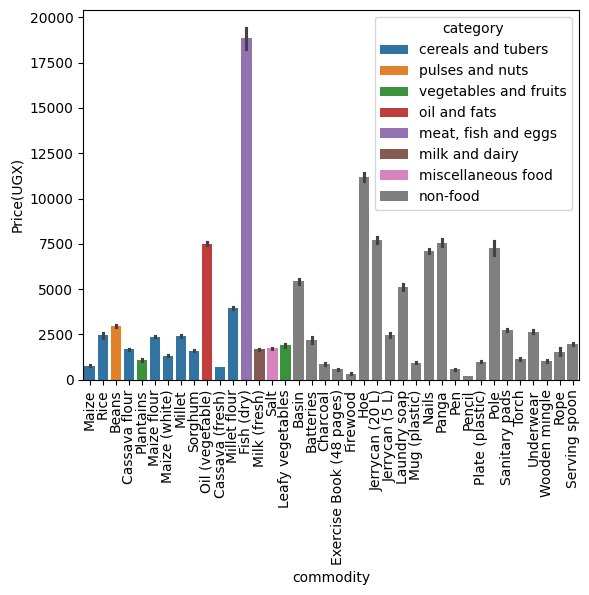

In [25]:
#exploratory data viz
#using a barplot to understand the data and search for trends between the numeric and categorical features.
# Using seaborn to plot the group means by waistcircumference colored by tryglycerides

ax = sns.barplot(data=df, x="commodity", y="Price(UGX)", hue='category')
plt.xticks(rotation=90)
plt.show()



In [26]:
df['date'] = pd.to_datetime(df['date'],errors='coerce')
df.head()


,date,District,Region,market,latitude,longitude,category,commodity,unit,priceflag,pricetype,Price(UGX),usdprice
1,2006-01-15,Busia,Samia-bugwe,Busia,0.467000,34.090000,cereals and tubers,Maize,KG,actual,Wholesale,298.40,0.1641
2,2006-01-15,Kampala,Central Kampala,Owino,0.322805,32.574841,cereals and tubers,Maize,KG,actual,Wholesale,345.42,0.1900
3,2006-01-15,Kampala,Central Kampala,Owino,0.322805,32.574841,cereals and tubers,Rice,KG,actual,Wholesale,1013.40,0.5573
4,2006-01-15,Lira,Lira Municipality,Lira,2.235000,32.909722,cereals and tubers,Maize,KG,actual,Wholesale,247.76,0.1362
5,2006-02-15,Busia,Samia-bugwe,Busia,0.467000,34.090000,cereals and tubers,Maize,KG,actual,Wholesale,296.59,0.1639


In [27]:
## now that we remove NaT's let's make our datetime index
df = df.set_index('date')
df.head(3)


,District,Region,market,latitude,longitude,category,commodity,unit,priceflag,pricetype,Price(UGX),usdprice
date,,,,,,,,,,,,
2006-01-15,Busia,Samia-bugwe,Busia,0.467000,34.090000,cereals and tubers,Maize,KG,actual,Wholesale,298.40,0.1641
2006-01-15,Kampala,Central Kampala,Owino,0.322805,32.574841,cereals and tubers,Maize,KG,actual,Wholesale,345.42,0.1900
2006-01-15,Kampala,Central Kampala,Owino,0.322805,32.574841,cereals and tubers,Rice,KG,actual,Wholesale,1013.40,0.5573


In [28]:
df = df.sort_index()
df.index



DatetimeIndex(['2006-01-15', '2006-01-15', '2006-01-15', '2006-01-15',
               '2006-02-15', '2006-02-15', '2006-02-15', '2006-02-15',
               '2006-03-15', '2006-03-15',
               ...
               '2024-05-15', '2024-05-15', '2024-05-15', '2024-05-15',
               '2024-05-15', '2024-05-15', '2024-05-15', '2024-05-15',
               '2024-05-15', '2024-05-15'],
              dtype='datetime64[ns]', name='date', length=23254, freq=None)

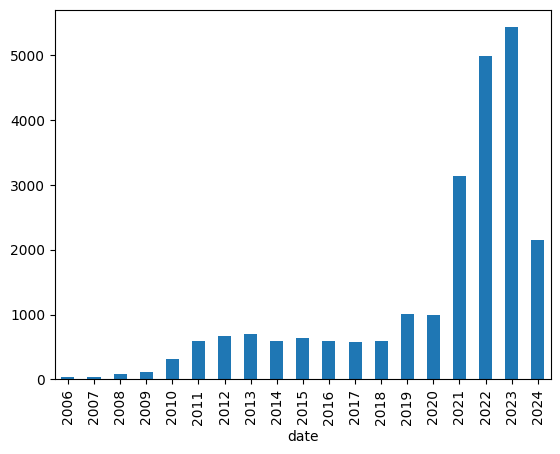

In [29]:
years = df.index.year
years.value_counts().sort_index().plot(kind='bar');


<Axes: ylabel='category'>

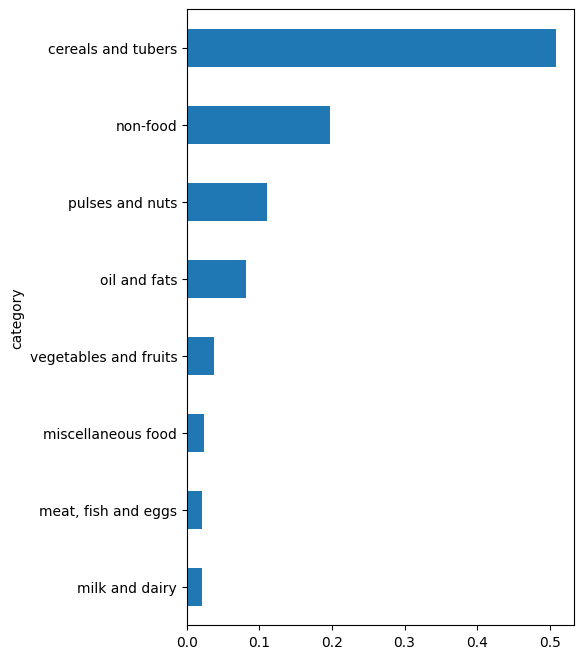

In [30]:
## Inspect the value_counts for the different types of crimes
items_sold = df['category'].value_counts(normalize=True)
items_sold.sort_values().plot(kind='barh',figsize=(5,8))


In [31]:
## Inspect the value_counts for the different types of crimes
items_sold = df['category'].value_counts().to_frame('Total # of items')
items_sold


,Total # of items
category,
cereals and tubers,11831
non-food,4576
pulses and nuts,2577
oil and fats,1902
vegetables and fruits,874
miscellaneous food,544
"meat, fish and eggs",482
milk and dairy,468


In [ ]:
## Inspect the value_counts for the different types of crimes
commodities = df['commodity'].value_counts().to_frame('Total # number of commodities')
commodities

,Total # number of commodities
commodity,
Beans,2577
Maize flour,2335
Maize (white),2211
Sorghum,2115
Oil (vegetable),1902
Cassava flour,1835
Millet,1378
Maize,736
Salt,544


#test train split

In [37]:
# Define X and y
target = 'Price(UGX)'
X = df.drop(columns = ['usdprice', 'Price(UGX)'])
y = df[target]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [38]:
# Categorical Preprocessing Pipeline
# Save list of column names
ohe_cols = X_train.select_dtypes('object').columns
print("OneHotEncoder Columns:", ohe_cols)
# Instantiate the individual preprocessors
impute_na = SimpleImputer(strategy='constant', fill_value = "0")
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
# Make pipeline with imputer and encoder
ohe_pipe = make_pipeline(impute_na, ohe_encoder)
# Making a ohe_tuple for ColumnTransformer
ohe_tuple = ('categorical', ohe_pipe, ohe_cols)
# Numerical Preprocessing Pipeline
# Save list of column names
num_cols = X_train.select_dtypes("number").columns
print("Numeric Columns:", num_cols)
# instantiate preprocessors
impute_median = SimpleImputer(strategy='median')
scaler = StandardScaler()
# Make a numeric preprocessing pipeline
num_pipe = make_pipeline(impute_median, scaler)
# Making a numeric tuple for ColumnTransformer
num_tuple = ('numeric', num_pipe, num_cols)
# Create the Column Transformer
preprocessor = ColumnTransformer([num_tuple, ohe_tuple],
                                 verbose_feature_names_out=False)
# fit the column transformer on X_train
preprocessor.fit(X_train)
# Transform X_train and X_test
X_train_tf = preprocessor.transform(X_train)
X_test_tf = preprocessor.transform(X_test)
X_train_tf.head()


OneHotEncoder Columns: Index(['District', 'Region', 'market', 'category', 'commodity', 'unit',
       'priceflag', 'pricetype'],
      dtype='object')
Numeric Columns: Index(['latitude', 'longitude'], dtype='object')


,latitude,longitude,District_Abim,District_Adjumani,District_Amudat,District_Arua,District_Busia,District_Gulu,District_Hoima,District_Iganga,District_Isingiro,District_Jinja,District_Kaabong,District_Kabale,District_Kabarole,District_Kampala,District_Kamwenge,District_Kasese,District_Kiryandongo,District_Koboko,District_Kotido,District_Kween,District_Kyankwanzi,District_Kyegegwa,District_Lamwo,District_Lira,District_Masaka,District_Masindi,District_Mbale,District_Mbarara,District_Moroto,District_Moyo,District_Mukono,District_Nakapiripirit,District_Napak,District_Soroti,District_Tororo,District_Wakiso,District_Yumbe,Region_Adjumani,Region_Aringa,Region_Arua Municipality,Region_Bokora,Region_Bugahya,Region_Buhaguzi,Region_Bukanga,Region_Buruli M,Region_Busiro,Region_Busongora,Region_Central Kampala,Region_Dodoth,Region_Fort Portal Municipality,Region_Gulu Municipality,Region_Jie,Region_Jinja Municipality,Region_Kabale Municipality,Region_Kadani,Region_Kibale,Region_Kibanda,Region_Kiboga,Region_Kigulu,Region_Koboko,Region_Kween,Region_Kyaka,Region_Labwor,Region_Lamwo,Region_Lira Municipality,Region_Masaka Municipality,Region_Mbale Municipality,Region_Mbarara Municipality,Region_Moroto Municipality,Region_Mukono,Region_Obongi,Region_Pian,Region_Samia-bugwe,Region_Soroti Municipality,Region_Terego,Region_Tororo Municipality,Region_Upe,market_Adjumani (refugee settlement),market_Arua,market_Bidibidi (refugee settlement),market_Busia,market_Fort Portal,market_Gulu,market_Hoima,market_Iganga,market_Imvepi (refugee settlement),market_Jinja,market_Kaabong,market_Kabale,market_Kapchorwa,market_Karenga,market_Karita,market_Kasese,market_Kiboga,market_Kiryandongo (refugee settlement),market_Kotido,market_Kyaka II (refugee settlement),market_Kyangwali (refugee settlement),market_Lira,market_Lobule (refugee settlement),market_Makaratin,market_Masaka,market_Masindi,market_Mbale,market_Mbarara,market_Moroto,market_Mukono,market_Nabilatuk,market_Nakivale (refugee settlement),market_Namalu,market_Napak,market_Oruchinga (refugee settlement),market_Owino,market_Palabek (refugee settlement),market_Palorinya (refugee settlement),market_Rhino Camp (refugee settlement),market_Rwamwanja (refugee settlement),market_Soroti,market_Tororo,market_Wakiso,category_cereals and tubers,"category_meat, fish and eggs",category_milk and dairy,category_miscellaneous food,category_non-food,category_oil and fats,category_pulses and nuts,category_vegetables and fruits,commodity_Basin,commodity_Batteries,commodity_Beans,commodity_Cassava (fresh),commodity_Cassava flour,commodity_Charcoal,commodity_Exercise Book (48 pages),commodity_Firewood,commodity_Fish (dry),commodity_Hoe,commodity_Jerrycan (20 L),commodity_Jerrycan (5 L),commodity_Laundry soap,commodity_Leafy vegetables,commodity_Maize,commodity_Maize (white),commodity_Maize flour,commodity_Milk (fresh),commodity_Millet,commodity_Millet flour,commodity_Mug (plastic),commodity_Nails,commodity_Oil (vegetable),commodity_Panga,commodity_Pen,commodity_Pencil,commodity_Plantains,commodity_Plate (plastic),commodity_Pole,commodity_Rice,commodity_Rope,commodity_Salt,commodity_Sanitary pads,commodity_Serving spoon,commodity_Sorghum,commodity_Torch,commodity_Underwear,commodity_Wooden mingle,unit_KG,unit_L,unit_Packet,unit_Pair,unit_Unit,priceflag_actual,pricetype_Retail,pricetype_Wholesale
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-05-15,1.279890,-0.941196,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [40]:
# scale the data
scaler=StandardScaler()
X_test_tf=scaler.fit_transform(X_test_tf)
X_train_tf=scaler.fit_transform(X_train_tf)



In [42]:
# Define shape
input_shape = X_train_tf.shape[1]
input_shape



176

In [43]:
# Build regression model within function
def build_model():
    # Instantiate Model
    model = Sequential()

    # First hidden layer
    model.add(Dense(10, # How many neurons you have in your first hidden layer
                input_dim =input_shape, # What is the shape of your input features (number of columns)
                activation = 'relu')) # What activation function are you using?
    model.add(Dense(10,
                activation = 'relu'))
    model.add(Dropout(.2))
    model.add(Dense(1, activation = 'linear'))

    # Compile Model
    model.compile(loss = 'mse', optimizer = 'adam',
             metrics=[metrics.MeanAbsoluteError(), metrics.RootMeanSquaredError()])
    return model



In [44]:
# Call our build function to build model
reg_model = build_model()

# Get model summary
reg_model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                1770      
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1891 (7.39 KB)
Trainable params: 1891 (7.39 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [45]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)



In [46]:
history = reg_model.fit(X_train_tf, y_train,
                        validation_split = .2,
                        epochs=100,
                        verbose=0, callbacks = [early_stop])



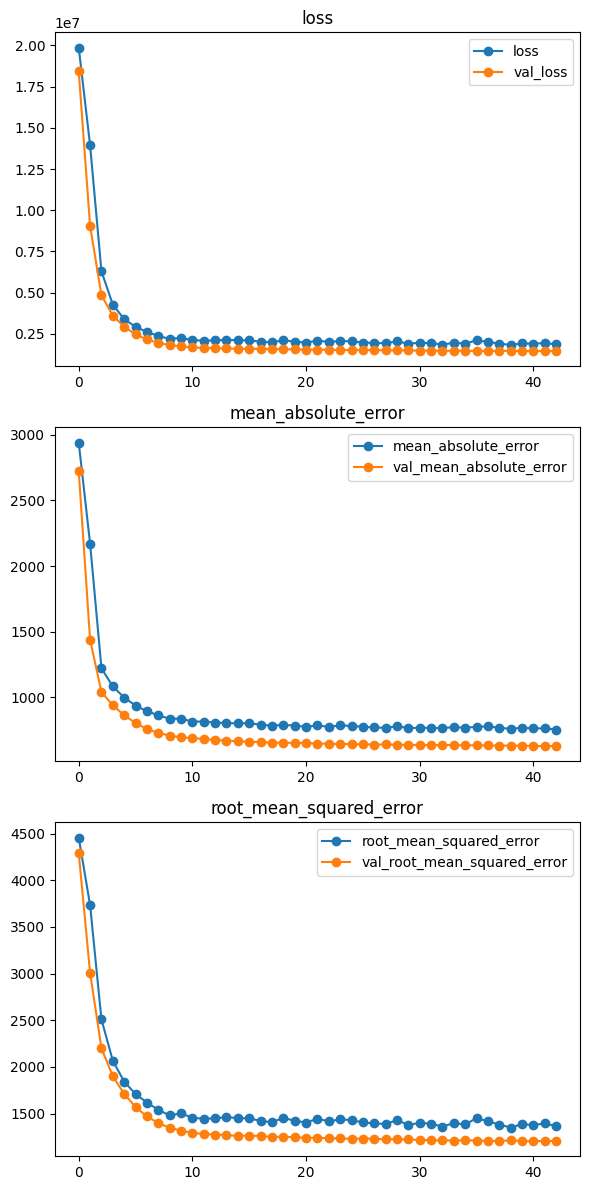

In [47]:
# plot learning
plot_history(history);



In [48]:
# evaluate model

y_pred = reg_model.predict(X_test_tf)

print(f'final RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'final MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'final R2: {r2_score(y_test, y_pred)}')


146/146 [==============================] - 0s 1ms/step
final RMSE: 1145.6588415348235
final MAE: 646.4677271875559
final R2: 0.8716076999386242


In [51]:
# Model 2: Add a layer and dropout for regularization
# Build regression model within function
def build_model():
    # Instantiate Model
    model = Sequential()

    # First hidden layer
    model.add(Dense(174, # How many neurons you have in your first hidden layer
                input_dim =input_shape, # What is the shape of your input features (number of columns)
                activation = 'relu')), # What activation function are you using?
    model.add(Dropout(.2))
    model.add(Dense(87,
                activation = 'relu'))
    model.add(Dropout(.2))
    model.add(Dense(44, activation = 'linear'))
    model.add(Dense(1))

    # Compile Model
    model.compile(loss = 'mse', optimizer = 'adam',
             metrics=[metrics.MeanAbsoluteError(), metrics.RootMeanSquaredError()])
    return model


# Call our build function to build model
reg_model2 = build_model()


from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

history2 = reg_model2.fit(X_train_tf, y_train,
                        validation_split = .2,
                        epochs=100,
                        verbose=0, callbacks = [early_stop])

# evaluate model

y_pred = reg_model.predict(X_test_tf)

print(f'final RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'final MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'final R2: {r2_score(y_test, y_pred)}')



146/146 [==============================] - 0s 3ms/step
final RMSE: 1145.6588415348235
final MAE: 646.4677271875559
final R2: 0.8716076999386242


In [56]:
# Model 2: Add a layer and dropout for regularization
model2 = Sequential([
    Dense(174, input_dim=input_shape, activation='relu'),
    Dropout(0.2),
    Dense(86, activation='relu'),
    Dropout(0.2),
    Dense(44, activation='relu'),
    Dense(1)
])
model2.compile(optimizer='adam', loss='mse')
history2 = model2.fit(X_train_tf, y_train, epochs=100, validation_split=0.2, verbose=0, callbacks=[EarlyStopping(patience=10)])

# evaluate model

y_pred = model2.predict(X_test_tf)

print(f'final RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'final MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'final R2: {r2_score(y_test, y_pred)}')



146/146 [==============================] - 0s 2ms/step
final RMSE: 1065.380525716972
final MAE: 610.3634927833374
final R2: 0.8889706327533906


In [57]:
model3 = Sequential([
    Dense(174, input_dim=input_shape, activation='relu'),
    Dropout(0.3),
    Dense(86, activation='relu'),
    Dropout(0.3),
    Dense(22, activation='relu'),
    Dense(10, activation='relu'),
    Dense(1)
])
model3.compile(optimizer='adam', loss='mse')
history3 = model3.fit(X_train_tf, y_train, epochs=100, validation_split=0.2, verbose=0, callbacks=[EarlyStopping(patience=10)])

# evaluate model

y_pred = model3.predict(X_test_tf)

print(f'final RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'final MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'final R2: {r2_score(y_test, y_pred)}')



146/146 [==============================] - 0s 2ms/step
final RMSE: 1068.483797968851
final MAE: 610.3414383494267
final R2: 0.8883228713943191
